<div style="text-align: left;">
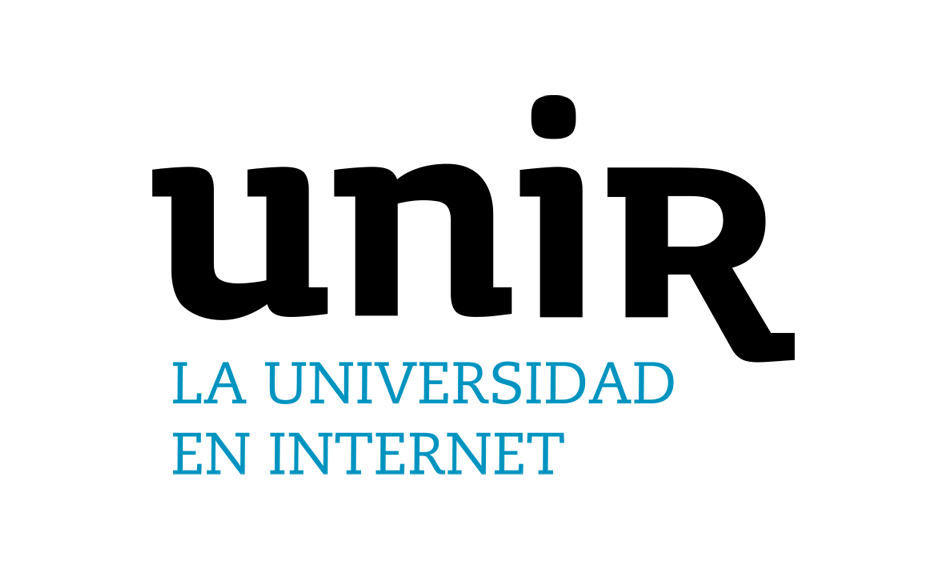
     <div>
        <h1>Tema 4: Valoración de opciones financieras con árboles binomiales</h1>
        <p>Dr. Miguel Angel Navarro Burgos</p>
        <p>Modelización y Valoración de Derivados y Carteras en Finanzas (MIMC)</p>
    </div>
</div>

# Calculo de $j^{\ast}$ y $V_0$

In [1]:
import numpy as np
from scipy.special import comb

def calculate_j_star(u, d, K, S_0, n, r):
    if d >= u:
        raise ValueError("d debe ser menor que u para que la fórmula tenga sentido.")
    j_star = np.ceil(np.log(K / (u**n * S_0)) / np.log(d / u))
    return int(j_star)  

def calculate_V0(u, d, K, S_0, n, r):
    q_star = (np.exp(r) - d) / (u - d)
    j_star = calculate_j_star(u, d, K, S_0, n, r)
    V_0 = np.exp(-r * n) * np.sum([comb(n, j) * (q_star ** (n - j)) * ((1 - q_star) ** j) *
            np.maximum((u ** (n - j)) * (d ** j) * S_0 - K, 0) for j in range(j_star + 1)])
    return V_0



# Ejemplo de llamada

In [2]:
# Ejemplo de uso
u, d = 1.1, 0.9
S_0, K = 100, 105
n = 3 #T=n
r = 0.05

V_0 = calculate_V0(u, d, K, S_0, n, r)
print(f'El valor de la opción V_0 es: {V_0:0.2f}')

El valor de la opción V_0 es: 11.87


# Generación de lista de los elementos del árbol binario

In [3]:
import numpy as np

q_star = (np.exp(r) - d) / (u - d)


A = [list(range(1, i + 1)) for i in range(1, n + 2)]
A[n] = [np.maximum((u ** (n - j)) * (d ** j) * S_0 - K, 0) for j in range(n + 1)] # Faltaba 'for' después de la coma
for i in range(n-1, -1, -1):
    A[i] = list(np.exp(-r) * (q_star * np.array(A[i+1][:-1]) + (1 - q_star) * np.array(A[i+1][1:])))
print(A)

[[11.868641351285868], [15.846116520195494, 2.0187710895146034], [21.120910427425045, 2.8059236000124796, 0.0], [28.10000000000005, 3.90000000000002, 0.0, 0.0]]


# Grafo del árbol bianrio utilizando la lista generada

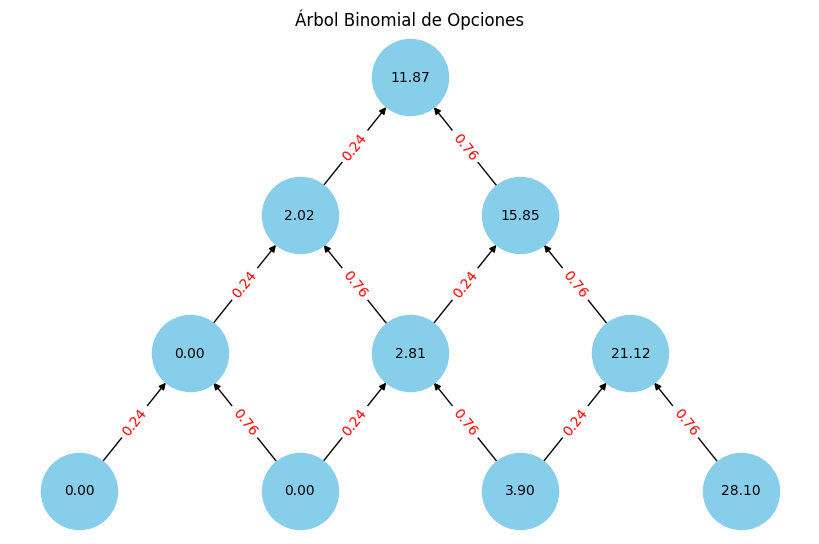

In [4]:
import matplotlib.pyplot as plt
import networkx as nx



import matplotlib.pyplot as plt
import networkx as nx

# Construir el árbol como grafo
G = nx.DiGraph()

# Agregar nodos y bordes con etiquetas
pos = {}  # Posiciones para los nodos para visualizar
labels = {}  # Etiquetas para los nodos
for i in range(len(A)):
    for j in range(len(A[i])):
        node_label = f'{A[i][j]:.2f}'
        G.add_node((i, j), label=node_label)
        labels[(i, j)] = node_label
        if i < len(A) - 1:  # Asegurar que no estamos en el último nivel
            G.add_edge((i + 1, j), (i, j), weight=f'{q_star:.2f}')
            G.add_edge((i + 1, j + 1), (i, j), weight=f'{1-q_star:.2f}')
        # Posiciones para dibujar (estilizar como árbol)
        pos[(i, j)] = (i - 2 * j, -i)

# Dibujar el grafo
plt.figure(figsize=(8, 5))
nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color='skyblue', font_size=10, font_color='black')
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}  # Etiquetas para las aristas
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title('Árbol Binomial de Opciones')
plt.show()


# Segundo grafo del árbol bianrio utilizando la lista generada

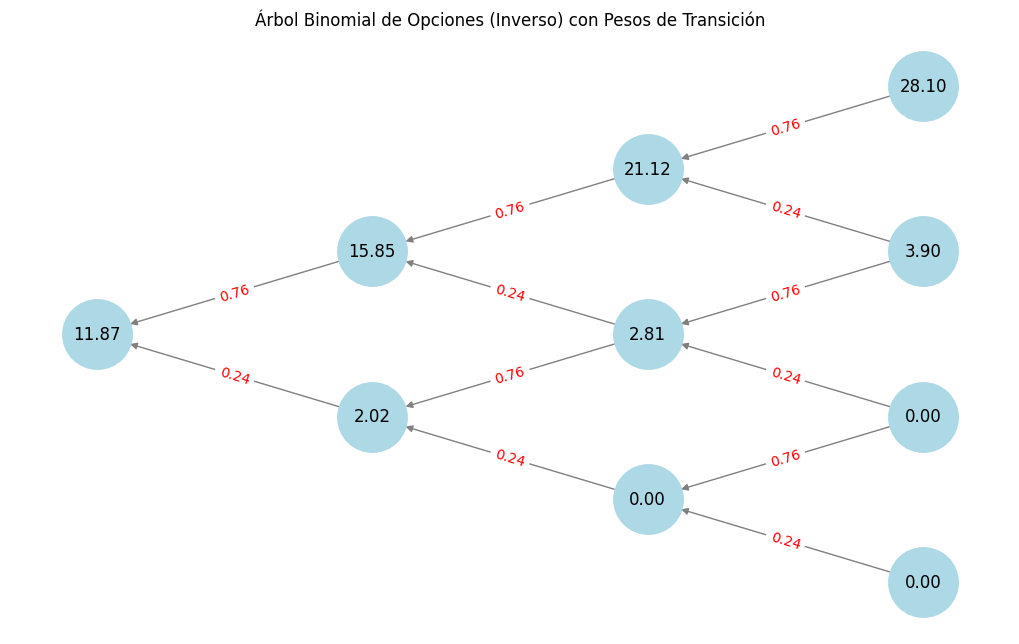

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

# Crear el grafo con las aristas en sentido inverso, indicando la progresión de la madurez hacia el presente

# Crear un nuevo grafo dirigido para manejar las direcciones de las aristas correctamente
G_inv = nx.DiGraph()
labels = {}  # Etiquetas para los nodos
# Agregar nodos y bordes con etiquetas y pesos, pero con aristas dirigidas hacia el tiempo presente
for i in range(len(A)):
    for j in range(len(A[i])):
        node_label = f'{A[i][j]:.2f}'
        G_inv.add_node((i, j), label=node_label, subset=i)  # Asignar el nivel como subset
        labels[(i, j)] = node_label
        if i < len(A) - 1:  # Asegurar que no estamos en el último nivel
            # Arista hacia el nodo derecho (q_star)
            G_inv.add_edge((i + 1, j), (i, j), weight=f'{q_star:.2f}')
            # Arista hacia el nodo izquierdo (1 - q_star)
            G_inv.add_edge((i + 1, j + 1), (i, j), weight=f'{1 - q_star:.2f}')

# Dibujar el grafo con los pesos de las aristas en el sentido correcto
plt.figure(figsize=(10, 6))
pos = nx.multipartite_layout(G_inv, subset_key='subset')  # Usar el atributo 'subset'
edge_labels = {(u, v): d['weight'] for u, v, d in G_inv.edges(data=True)}  # Etiquetas para las aristas

nx.draw(G_inv, pos, with_labels=True, labels=labels, node_size=2500, node_color='lightblue', font_size=12, font_color='black', edge_color='gray')
nx.draw_networkx_edge_labels(G_inv, pos, edge_labels=edge_labels, font_color='red')
plt.title('Árbol Binomial de Opciones (Inverso) con Pesos de Transición')
plt.show()

# Código de algoritmo Hull-White

In [6]:
import numpy as np

S=np.array([29.56,30.125,28.56,27.50,28.125,27.44,
27.06,27.125,28.69,27.94,27.25])

U=S[1:]/S[:-1]-1
mu=np.mean(U)
sigma=np.std(U,ddof=1)#S con N-1=N-ddof

u=1+mu+sigma
d=1+mu-sigma

print(f'u={u:0.5f} y d={d:0.5f}')

u=1.02537 y d=0.95940


# Importando archivo .csv

In [7]:
import numpy as np
import pandas as pd

# Cargar los datos desde el archivo CSV sin encabezado
S = np.array(pd.read_csv('datos_S.csv', header=None))

# Calcular los rendimientos diarios
# Asegúrate de trabajar con flotantes para evitar problemas de división entera en versiones de Python anteriores
U = S[1:] / S[:-1] - 1

# Calcular la media y la desviación estándar de los rendimientos
mu = np.mean(U)
sigma = np.std(U, ddof=1)  # Uso de N-1 para una muestra

# Calcular u y d para el modelo de movimiento Browniano geométrico
u = 1 + mu + sigma
d = 1 + mu - sigma

# Mostrar los resultados
print(f'u={u:0.5f} y d={d:0.5f}')


u=1.02537 y d=0.95940


In [8]:
import pandas as pd
import numpy as np

# Cargar los datos desde el archivo CSV 'datos_S.csv' sin encabezado
S = pd.read_csv('datos_S.csv', header=None, names=['Precio'])

# Calcular los rendimientos diarios manualmente y agregar un NaN al final y asignar los rendimientos al DataFrame
S['Rendimientos'] =  np.append(S['Precio'].iloc[1:].values / S['Precio'].iloc[:-1].values - 1, np.nan)

# Calcular la media y la desviación estándar de los rendimientos, pandas excluye NaN automáticamente
mu = S['Rendimientos'].mean()
sigma = S['Rendimientos'].std(ddof=1)

# Calcular u y d para el modelo de movimiento Browniano geométrico
u = 1 + mu + sigma
d = 1 + mu - sigma

# Mostrar los resultados y el DataFrame
print(f'u={u:0.5f} y d={d:0.5f}')
print(S)


u=1.02537 y d=0.95940
    Precio  Rendimientos
0   29.560      0.019114
1   30.125     -0.051950
2   28.560     -0.037115
3   27.500      0.022727
4   28.125     -0.024356
5   27.440     -0.013848
6   27.060      0.002402
7   27.125      0.057696
8   28.690     -0.026142
9   27.940     -0.024696
10  27.250           NaN


# Opción de Python .pct_change()

In [9]:
import pandas as pd
import numpy as np

# Cargar los datos desde el archivo CSV 'datos_S.csv' sin encabezado
S = pd.read_csv('datos_S.csv', header=None, names=['Precio'])

# Calcular los rendimientos diarios utilizando pct_change()
S['Rendimientos'] = S['Precio'].pct_change()

# Calcular la media y la desviación estándar de los rendimientos
mu = S['Rendimientos'].mean()
sigma = S['Rendimientos'].std(ddof=1)

# Calcular u y d para el modelo de movimiento Browniano geométrico
u = 1 + mu + sigma
d = 1 + mu - sigma

# Mostrar los resultados y el DataFrame
print(f'u={u:0.5f} y d={d:0.5f}')
print(S)


u=1.02537 y d=0.95940
    Precio  Rendimientos
0   29.560           NaN
1   30.125      0.019114
2   28.560     -0.051950
3   27.500     -0.037115
4   28.125      0.022727
5   27.440     -0.024356
6   27.060     -0.013848
7   27.125      0.002402
8   28.690      0.057696
9   27.940     -0.026142
10  27.250     -0.024696
